In [35]:
import math
import random 
import numpy as np

class Value:
    def __init__(self, data, _children=(), _op = ""):
        self.data = data
        self.grad = 0

        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op 
        
    def backward(self):
        visited = set()
        topo = []
        
        def build_topo(v):
            if(v not in visited):
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        return
    
    # def tanh(self):
    #     x = self.data
    #     th = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
    #     ret = Value(th, (self, ), "tanh")

    #     def _backward():
    #         self.grad += (1 - th ** 2) * ret.grad
    #     ret._backward = _backward
    #     return ret
    
    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def relu(self):
        x = self.data
        ret = Value(max(0, x), (self, ), "relu")
        def _backward():
            temp = 1 if ret.data > 0 else 0
            self.grad += temp * ret.grad
        ret._backward = _backward
        return ret
    
    def sigmoid(self):
        x = self.data
        sig = 1 / (1 + math.exp(-x))
        ret = Value(sig, (self, ), "sigmoid")
        def _backward():
            self.grad = (sig * (1 - sig)) * ret.grad
        ret._backward = _backward
        return ret
    
    def __add__(self, other):  
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += ret.grad
            other.grad += ret.grad
        ret._backward = _backward

        return ret
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * ret.grad
            other.grad += self.data *ret.grad
        ret._backward = _backward

        return ret
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only int / float powers are supported"
        ret = Value(self.data ** other, (self, ), "**{other}")
        def _backward():
            self.grad += other * self.data ** (other - 1) * ret.grad
        ret._backward = _backward
        return ret
    
    def __neg__(self):
        return self * (-1)
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return self - other
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other
    def __truediv__(self, other):
        return self * other ** -1
    def __rtruediv__(self, other):
        return other * self ** -1
    def __repr__(self):
        return f"Value(data = {self.data}, grad = {self.grad})"
    
    


In [36]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [37]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
    def __call__(self, x):
        act = sum(wi * xi for wi, xi in zip(self.w, x))
        return act.tanh()
    def parameters(self):
        return self.w + [self.b]
    def __repr__(self):
        return f"Neuron({len(self.w)})"

class Layer:
    def __init__(self, nin, nou):
        self.neurons = [Neuron(nin) for _ in range(nou)]
    def __call__(self, x):
        ret = [n(x) for n in self.neurons]
        return ret if len(self.neurons) > 1 else ret[0]
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    def __repr__(self):
        return f"Layer({len(self.neurons)})"

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x       
    def parameters(self):
        return [p  for l in self.layers for p in l.parameters()]
    def __repr__(self):
        return f"MLP({len(self.layers)})"




In [54]:
mlp = MLP(3, [7, 8, 1])

# xs = [
#   [2.0, 3.0, -12.0],
#   [3.0, -1.0, 100.5],
#   [0.5, 1.0, 1.0],
#   [1.0, 1.0, -1.0],
# ]
# ys = [1.0, -1.0, -1.0, 1.0]
xs = [
  [2, 3, -12],
  [3, -1, 101],
  [0, 1, 1],
  [1, 1, -1],
]

ys = [1, -1, 2, 1]



In [61]:
ans = []
for k in range(20):
  
  # forward pass
  ypred = [mlp(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in mlp.parameters():
    p.data += -0.01 * p.grad
  
  print(k, loss.data)
  ans = ypred
  
for i in range(len(ans)):
  ans[i] = ans[i].data
print(ans)



0 nan
1 nan
2 nan
3 nan
4 nan
5 nan
6 nan
7 nan
8 nan
9 nan
10 nan
11 nan
12 nan
13 nan
14 nan
15 nan
16 nan
17 nan
18 nan
19 nan
[nan, nan, nan, nan]


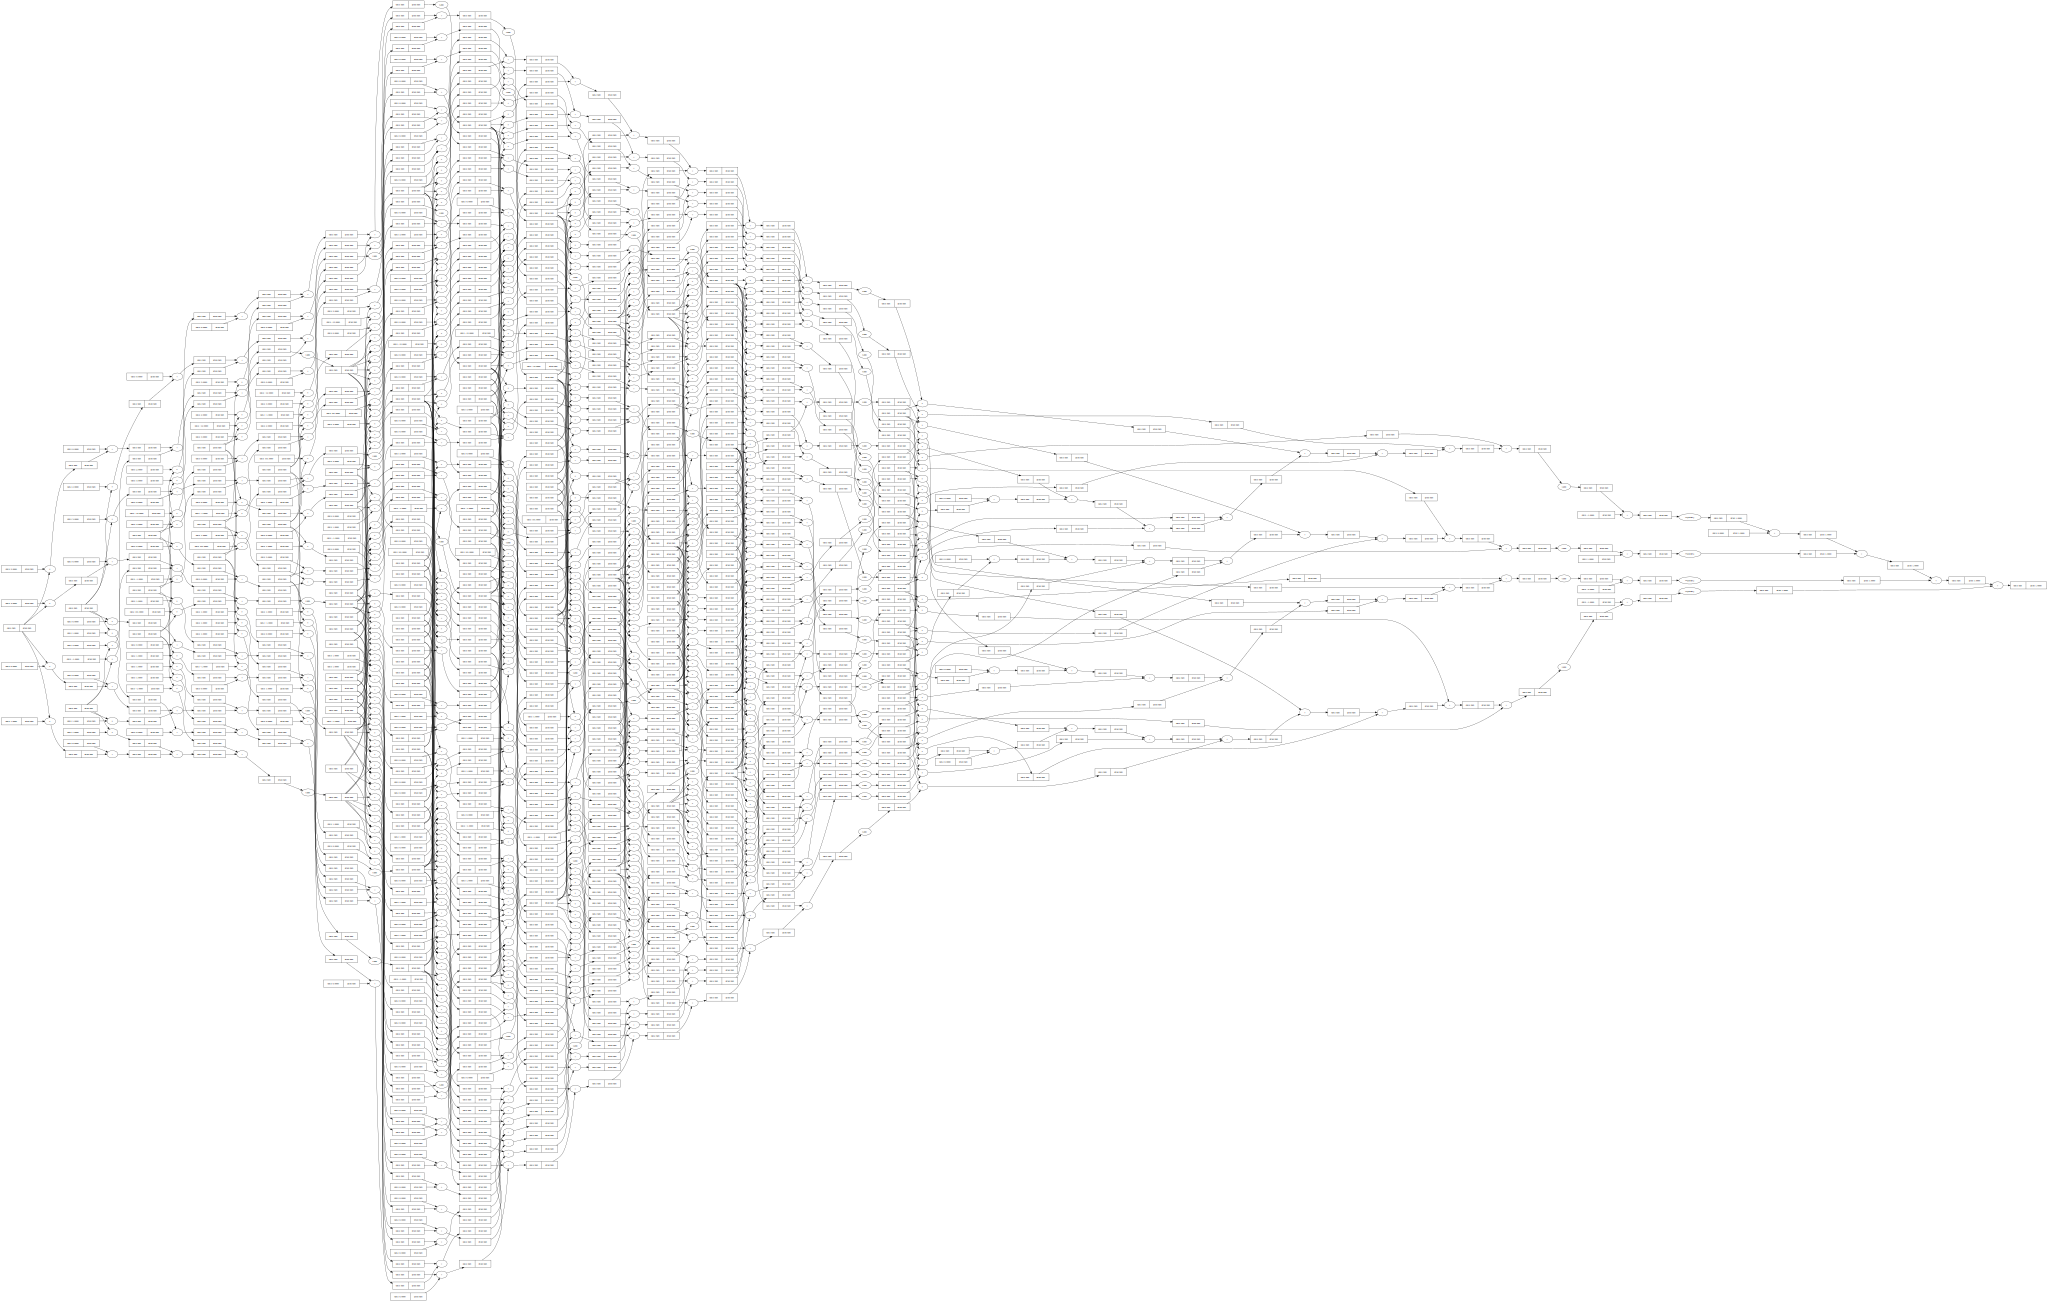

In [62]:
draw_dot(loss)